In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms

print(torch.__version__)
print(torchvision.__version__)

2.1.1+cu118
0.16.1+cu118


Learning pytorch (Использует граф вычислений в отличии от нампай это позволяет сохранять зависимости)
MNIST - popular image dataset of handwritten digits

In [2]:
from torch import nn
from torch.nn import functional as F

In [3]:
# We can use MNIST directly from torchvision but I will use from sklearn, convert it to pandas.DataFrame in order get more practice
from sklearn.datasets import load_digits # MNIST - simple datasets that consists 8x8 images of handwritten digits
features = pd.DataFrame(load_digits().data)
target = pd.DataFrame(load_digits().target)
print( len(features) )
features.head(5)

1797


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [4]:
target.head(5)

,0
0,0
1,1
2,2
3,3
4,4


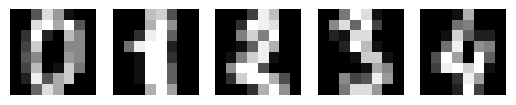

In [5]:
# Visualization of first 5 digits
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.reshape(features.iloc[i].values, (8, 8)), cmap='gray')
    plt.axis('off')

In [6]:
# Creating dataset class
class DatasetMNIST(Dataset):
    def __init__(self, features, target, transform = None) -> None:
        self.data = features.values
        self.labels = target.values
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index].reshape(8, 8, 1)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)
            
        return image, label
    

In [7]:
#Simple transormation composition
class Flatten():
    def __call__(self, pic):
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + '()'

# We can apply bunch of transformations using Compose
my_transformation = transforms.Compose( [transforms.ToTensor(), Flatten()] )
my_dataset = DatasetMNIST(features, target, my_transformation)

# Try to get 1st observation
print( my_dataset[0][0].shape, type(my_dataset[0][1]))

torch.Size([64]) <class 'numpy.ndarray'>


In [8]:
# Advantage of pytorch - we can use GPU`s power and memory for calculations`
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

# It is good practive to use only this way because we might need to implement model on device without GPU
# If tensord located separately on CPU and GPU, they can not interact with each others

# Example how it is works
#--random_tensor.to(device)

device(type='cuda')

In [9]:
# Usually our training and validating data should be separated but if not we can use torch.utils.data.Subset to separate it
def subset_ind(dataset, ratio: float):
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

validating_ratio = 0.25
shrink_inds = subset_ind(my_dataset, validating_ratio)
train_dataset = Subset(my_dataset, [i for i in range(len(my_dataset)) if i not in shrink_inds])
val_dataset = Subset(my_dataset, shrink_inds)
print( "train size: {}, validation size: {}".format( len(train_dataset), len(val_dataset) ))
len(features) == len(train_dataset) + len(val_dataset)

train size: 1348, validation size: 449


True

In [10]:
# Working with Dataloader
train_dataloader = DataLoader(train_dataset, batch_size= 72, shuffle=True)
train_dataloader_iter = iter(train_dataloader)

# It is good practice for validating data disable shuffling
val_loader = DataLoader(val_dataset, batch_size= 72, shuffle=False)
val_loader_iter = iter(val_loader)

images, labels = next(train_dataloader_iter)

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))
# print(type(labels.squeeze()))

images shape on batch size = torch.Size([72, 64])
labels shape on batch size = torch.Size([72, 1])


In [11]:
# Warning: In pytorch implementation CrossEntropyLoss combines both the softmax activation and the negative log likelihood loss
criterion = nn.CrossEntropyLoss()

# Creating model
# We do not use softmax of sigmoid because as I said above we have softmax in our criterion, so we just need to output (x_batch_size, 10) for our criterion to find loss and start backward
my_model = nn.Sequential(
    nn.BatchNorm1d(64),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 10),
)
my_model.to(device, torch.double)
optimizer = torch.optim.Adam(my_model.parameters(), lr = 2e-3)

# a = torch.rand(3,10, requires_grad=True)
# b = torch.empty(3, dtype=torch.long).random_(5)
# print(criterion(a, b), a.shape, b.shape)

In [12]:
import time
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.squeeze().type(torch.LongTensor).to(device)

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            y_pred = model(X_batch)
            # print(y_pred)

            loss = loss_fn(y_pred, y_batch)

            loss.backward()
            opt.step()
            opt.zero_grad()
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad(): 
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.squeeze().type(torch.LongTensor).to(device)

                # compute predictions
                y_pred = model(X_batch)
                # print(y_batch.shape, y_pred.shape)
                loss = loss_fn(y_pred, y_batch)

                ep_val_loss.append(loss.item())
                y_pred = y_pred.max(dim=1)[1]
                ep_val_accuracy.append(((y_pred == y_batch).detach().cpu().numpy().mean()))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        # print( type(ep_val_loss[0]) )
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy


n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(my_model, train_dataloader, val_loader, criterion, optimizer, n_epochs)

Epoch 1 of 30 took 2.525s
	  training loss: 2.027993
	validation loss: 1.726339
	validation accuracy: 0.655
Epoch 2 of 30 took 0.114s
	  training loss: 1.448311
	validation loss: 1.178916
	validation accuracy: 0.786
Epoch 3 of 30 took 0.135s
	  training loss: 0.908403
	validation loss: 0.697959
	validation accuracy: 0.888
Epoch 4 of 30 took 0.122s
	  training loss: 0.542470
	validation loss: 0.420317
	validation accuracy: 0.916
Epoch 5 of 30 took 0.148s
	  training loss: 0.351681
	validation loss: 0.295082
	validation accuracy: 0.930
Epoch 6 of 30 took 0.126s
	  training loss: 0.261542
	validation loss: 0.226230
	validation accuracy: 0.936
Epoch 7 of 30 took 0.130s
	  training loss: 0.202916
	validation loss: 0.192210
	validation accuracy: 0.948
Epoch 8 of 30 took 0.115s
	  training loss: 0.168823
	validation loss: 0.168163
	validation accuracy: 0.952
Epoch 9 of 30 took 0.111s
	  training loss: 0.139237
	validation loss: 0.147616
	validation accuracy: 0.964
Epoch 10 of 30 took 0.114s
	

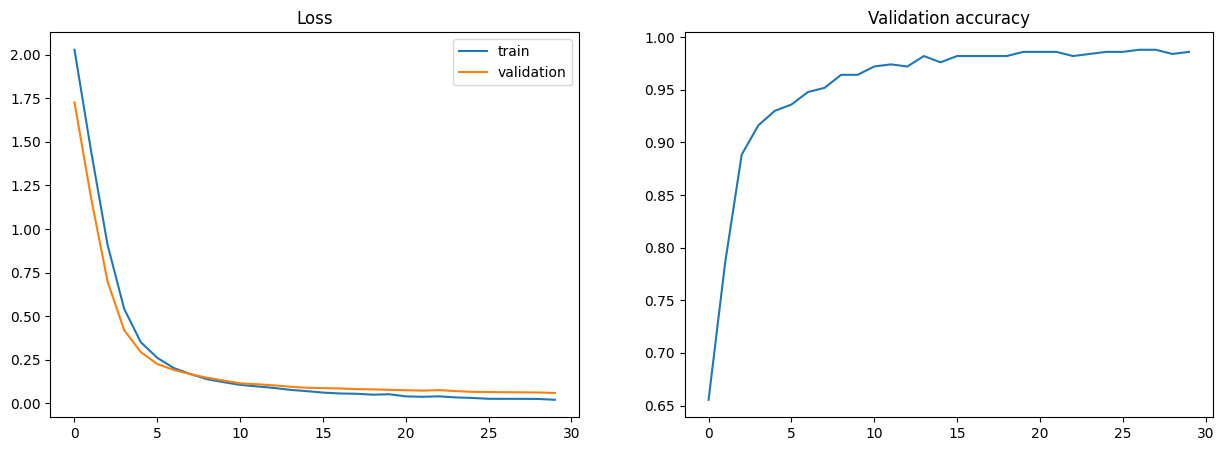

In [13]:
# Visualization
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

plot_train_process(train_loss, val_loss, val_accuracy)

In [14]:
# It is very important be able to save and create such 'Point' to be able to rollback, test and etc.
# Idea is simple - model is actually literally some weights, numerical data, we just save these parameters

def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)

# When we need to for example to complete training, we just need to restore architecture of model, get parameters and we can continue learning process or if we saw that model is going to overfit, we can rollback and fix problems 
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)